In [1]:
import pandas as pd
import re

from transformers import pipeline, AutoModelForSequenceClassification, AutoTokenizer

from pandarallel import pandarallel

2023-07-31 15:30:57.453519: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-31 15:31:01.424608: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-07-31 15:31:01.424638: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-07-31 15:31:11.108402: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [72]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "true"

In [2]:
df_presconf = pd.read_csv('../data/df_presconf.csv')
df_presconf.shape

(1276, 9)

In [3]:
pd.set_option('mode.chained_assignment', None)

In [4]:
# Initialization
pandarallel.initialize(progress_bar=True)  # Turn on progress_bar if you wish


INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [5]:
# Load sentiment analysis model
def load_sentiment_model(model_name):
    model = AutoModelForSequenceClassification.from_pretrained(model_name)
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    sentiment_analysis = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer)
    return sentiment_analysis

In [6]:
# Load models globally
sentiment_analysis = load_sentiment_model("ProsusAI/finbert")
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")
candidate_labels = ["Monetary Policy", "Macro Economy", "Major Events"]

In [7]:
def clean_text(text):
    # 1. Remove speaker identifications
    text = re.sub(r'\b[A-Z\s]+\.', '', text)
    
    # 2. Combine split words while making exceptions for common 1-2 letter words
    exceptions = [
        'a', 'I', 'it', 'an', 'be', 'by', 'do', 'he', 'if', 
        'in', 'is', 'it', 'no', 'of', 'on', 'or', 'so', 'to', 
        'up', 'we'
    ]
    exceptions_pattern = '|'.join(map(re.escape, exceptions))
    pattern = r'\b(?!' + exceptions_pattern + r'\b)(\w{1,2})\s(?=[a-z]{1,2}\b)'
    text = re.sub(pattern, r'\1', text)
    
    # 3. Replace line breaks and extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    # 4. Replace all special characters
    text = re.sub(r'[^\w\s]', ' ', text)
    
    # 5. Remove metadata like date and "7 of 26"
    text = re.sub(r'\b\w+ \d+, \d+.*?Press Conference.*?\d+ of \d+\b', '', text)
    
    # 6. Remove any stray sequences that still look like dates
    text = re.sub(r'\b\w+ \d+, \d+\b', '', text)
    
    # 7. Lower the text
    text = text.lower()
    
    return text

In [60]:
# def aggregate_sentiment(text):
#     segments = [text[i: i + 500] for i in range(0, len(text), 500)]
#     sentiment_scores = {'positive': 1, 'neutral': 0, 'negative': -1}
#     sentiments = [{'label': sentiment_analysis(seg)[0]['label'], 'score': sentiment_analysis(seg)[0]['score'], 'length': len(seg)} for seg in segments]
#     sent_score = sum([sent['length'] * sent['score'] * sentiment_scores[sent['label']] for sent in sentiments]) / len(text)
#     return sent_score

In [58]:
# def aggregate_sentiment(text):
#     segments = [text[i: i + 500] for i in range(0, len(text), 500)]
#     sentiment_scores = {'positive': 1, 'neutral': 0, 'negative': -1}
#     sentiments = [{'label': sentiment_analysis(seg)[0]['label'], 'score': sentiment_analysis(seg)[0]['score'], 'length': len(seg)} for seg in segments]
    
#     # If all segments are neutral, return 0
#     if all([sent['label'] == 'neutral' for sent in sentiments]):
#         return 0
    
#     sentiments = [sent for sent in sentiments if sent['label'] != 'neutral']
    
#     # Calculate the aggregated score
#     total_length = sum([sent['length'] for sent in sentiments])
#     sent_score = sum([sent['length'] * sent['score'] * sentiment_scores[sent['label']] for sent in sentiments]) / total_length
    
#     return sent_score

In [64]:
def aggregate_sentiment(text):
    
    if not text or pd.isna(text):
        return (0, 0, [])
    
    segments = [text[i: i + 500] for i in range(0, len(text), 500)]
    sentiment_scores = {'positive': 1, 'neutral': 0, 'negative': -1}
    
    sentiments = [{'label': sentiment_analysis(seg)[0]['label'], 
                   'score': sentiment_analysis(seg)[0]['score'], 
                   'length': len(seg)} for seg in segments]
    
    # If all segments are neutral, aggregated score is 0
    if all([sent['label'] == 'neutral' for sent in sentiments]):
        aggregated_score_no_neutral = 0
    else:
        non_neutral_sentiments = [sent for sent in sentiments if sent['label'] != 'neutral']
        total_length_non_neutral = sum([sent['length'] for sent in non_neutral_sentiments])
        aggregated_score_no_neutral = sum([sent['length'] * sent['score'] * sentiment_scores[sent['label']] 
                                           for sent in non_neutral_sentiments]) / total_length_non_neutral

    # Calculate the overall aggregated score without filtering
    total_length = sum([sent['length'] for sent in sentiments])
    aggregated_score = sum([sent['length'] * sent['score'] * sentiment_scores[sent['label']] 
                            for sent in sentiments]) / total_length
    
    return aggregated_score_no_neutral, aggregated_score, sentiments

In [9]:
def classify_text(text):
    output = classifier(text, candidate_labels)
    return output['labels'][0]

In [74]:
def process_dataframe(df):
    # 1. Clean the text
    df['CleanedText'] = df['segment_text'].parallel_apply(clean_text)
    
    # 2. Apply sentiment aggregation
    df['AggregatedScoreNoNeutral'], df['AggregatedScore'], df['RawSentiments'] = zip(*df['CleanedText'].apply(aggregate_sentiment))
    
    # 3. Classify the text
    df['Category'] = df['CleanedText'].apply(classify_text)
    
    # 4. Reorganize and rename the dataframe columns for the result
    result_df = df[['date', 'Category', 'AggregatedScoreNoNeutral', 'AggregatedScore','RawSentiments', 'segment']].rename(
        columns={'date': 'date','Category': 'category', 'AggregatedScoreNoNeutral': 'sentiment_score_1',
                 'AggregatedScore': 'sentiment_score_2','RawSentiments': 'sentiments'})
    
    return result_df


In [ ]:
%%time

df_sentiment = process_dataframe(df_presconf)

In [ ]:
df_sentiment.to_csv('df_sentiment.csv')

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
df = pd.read_csv('df_sentiment.csv')

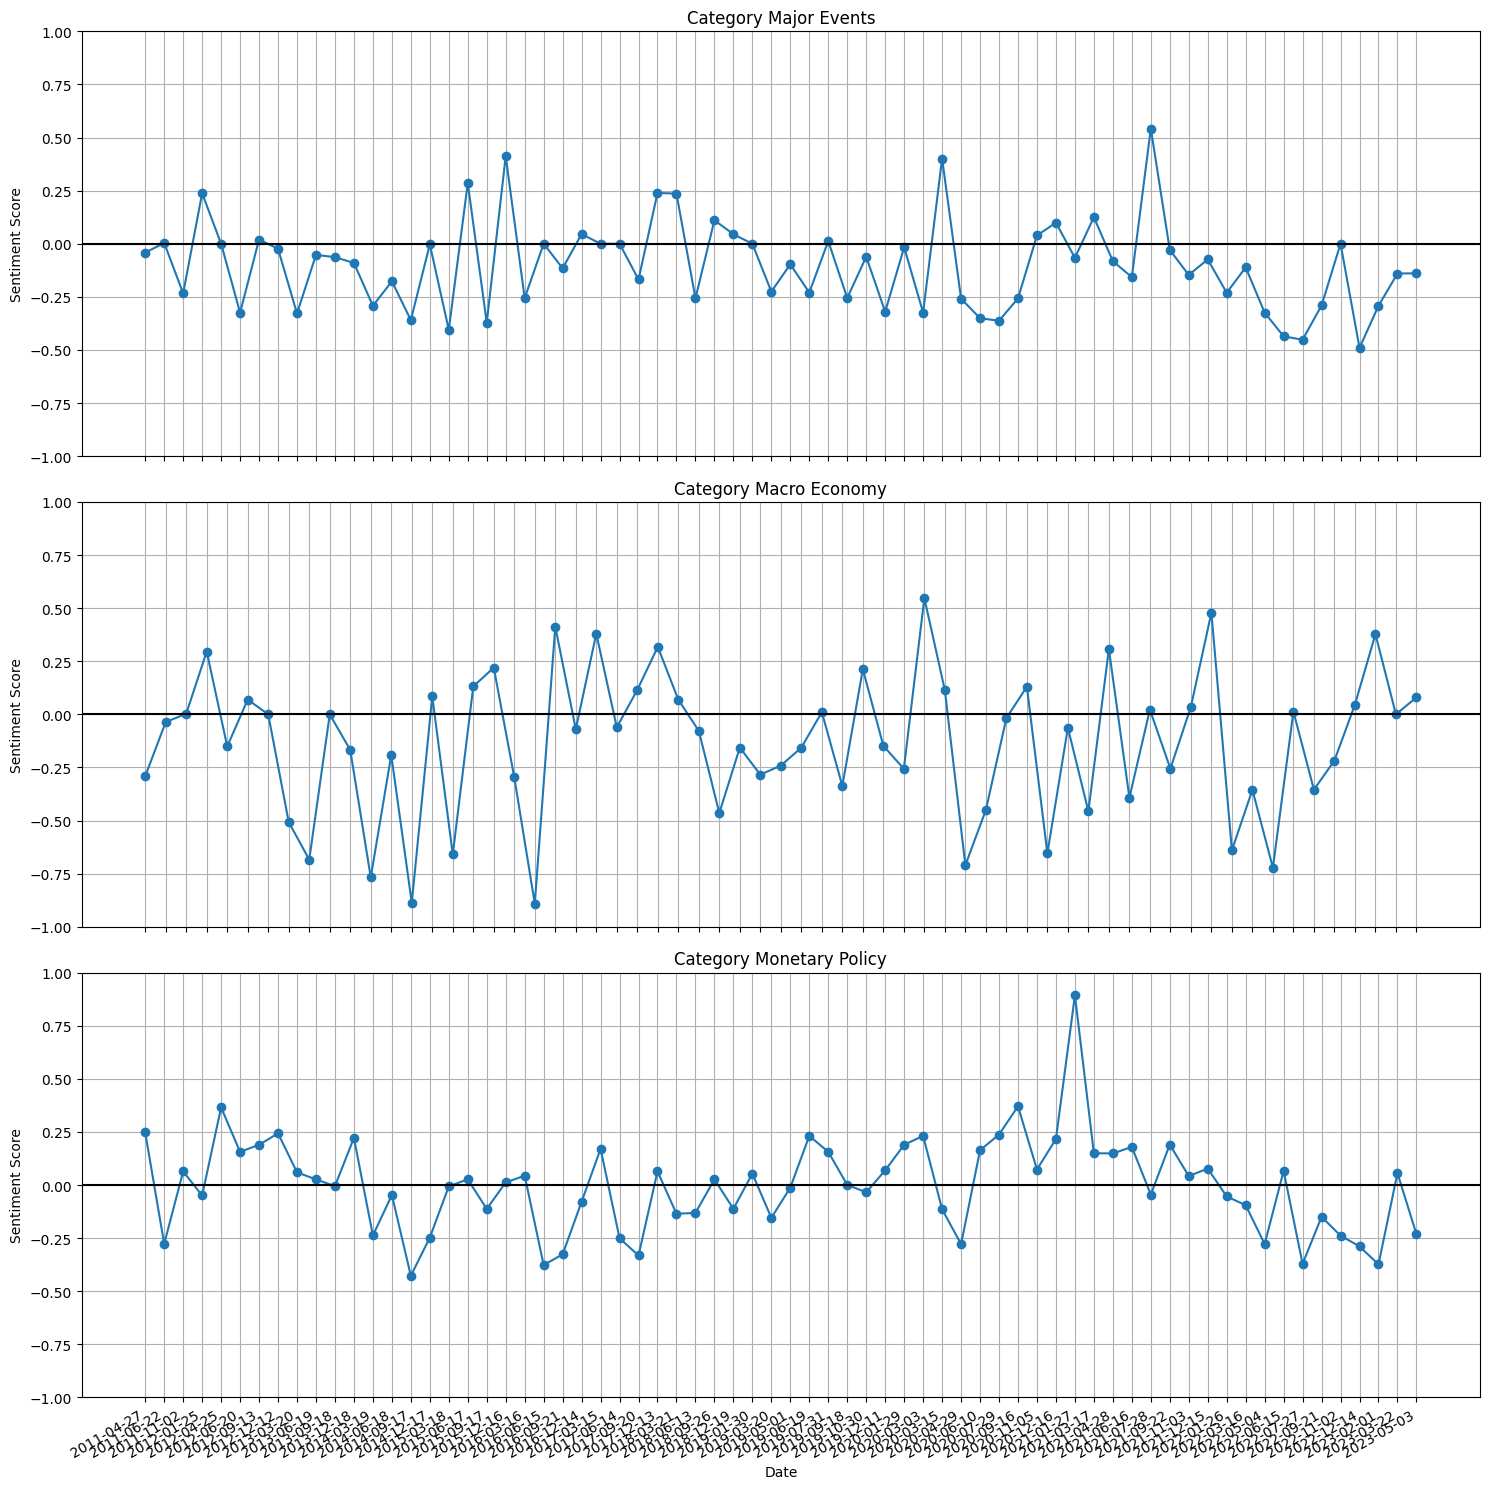

<Figure size 640x480 with 0 Axes>

In [14]:
agg_df = df.groupby(['date', 'category']).mean().reset_index()

# Plotting
fig, axes = plt.subplots(3, 1, figsize=(15, 15))

categories = df['category'].unique()

for i, category in enumerate(categories):
    subset = agg_df[agg_df['category'] == category]
    axes[i].plot(subset['date'], subset['sentiment_score_1'], marker='o')
    axes[i].set_title(f'Category {category}')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Sentiment Score')
    axes[i].grid(True)
    axes[i].set_ylim([-1, 1])  # Assuming sentiment score is between -1 and 1
    axes[i].axhline(0, color='black', linewidth=1.5)
    fig.autofmt_xdate()  # Rotate x-labels for better formatting

plt.tight_layout()
plt.show()
plt.savefig('sentiment.jpg')

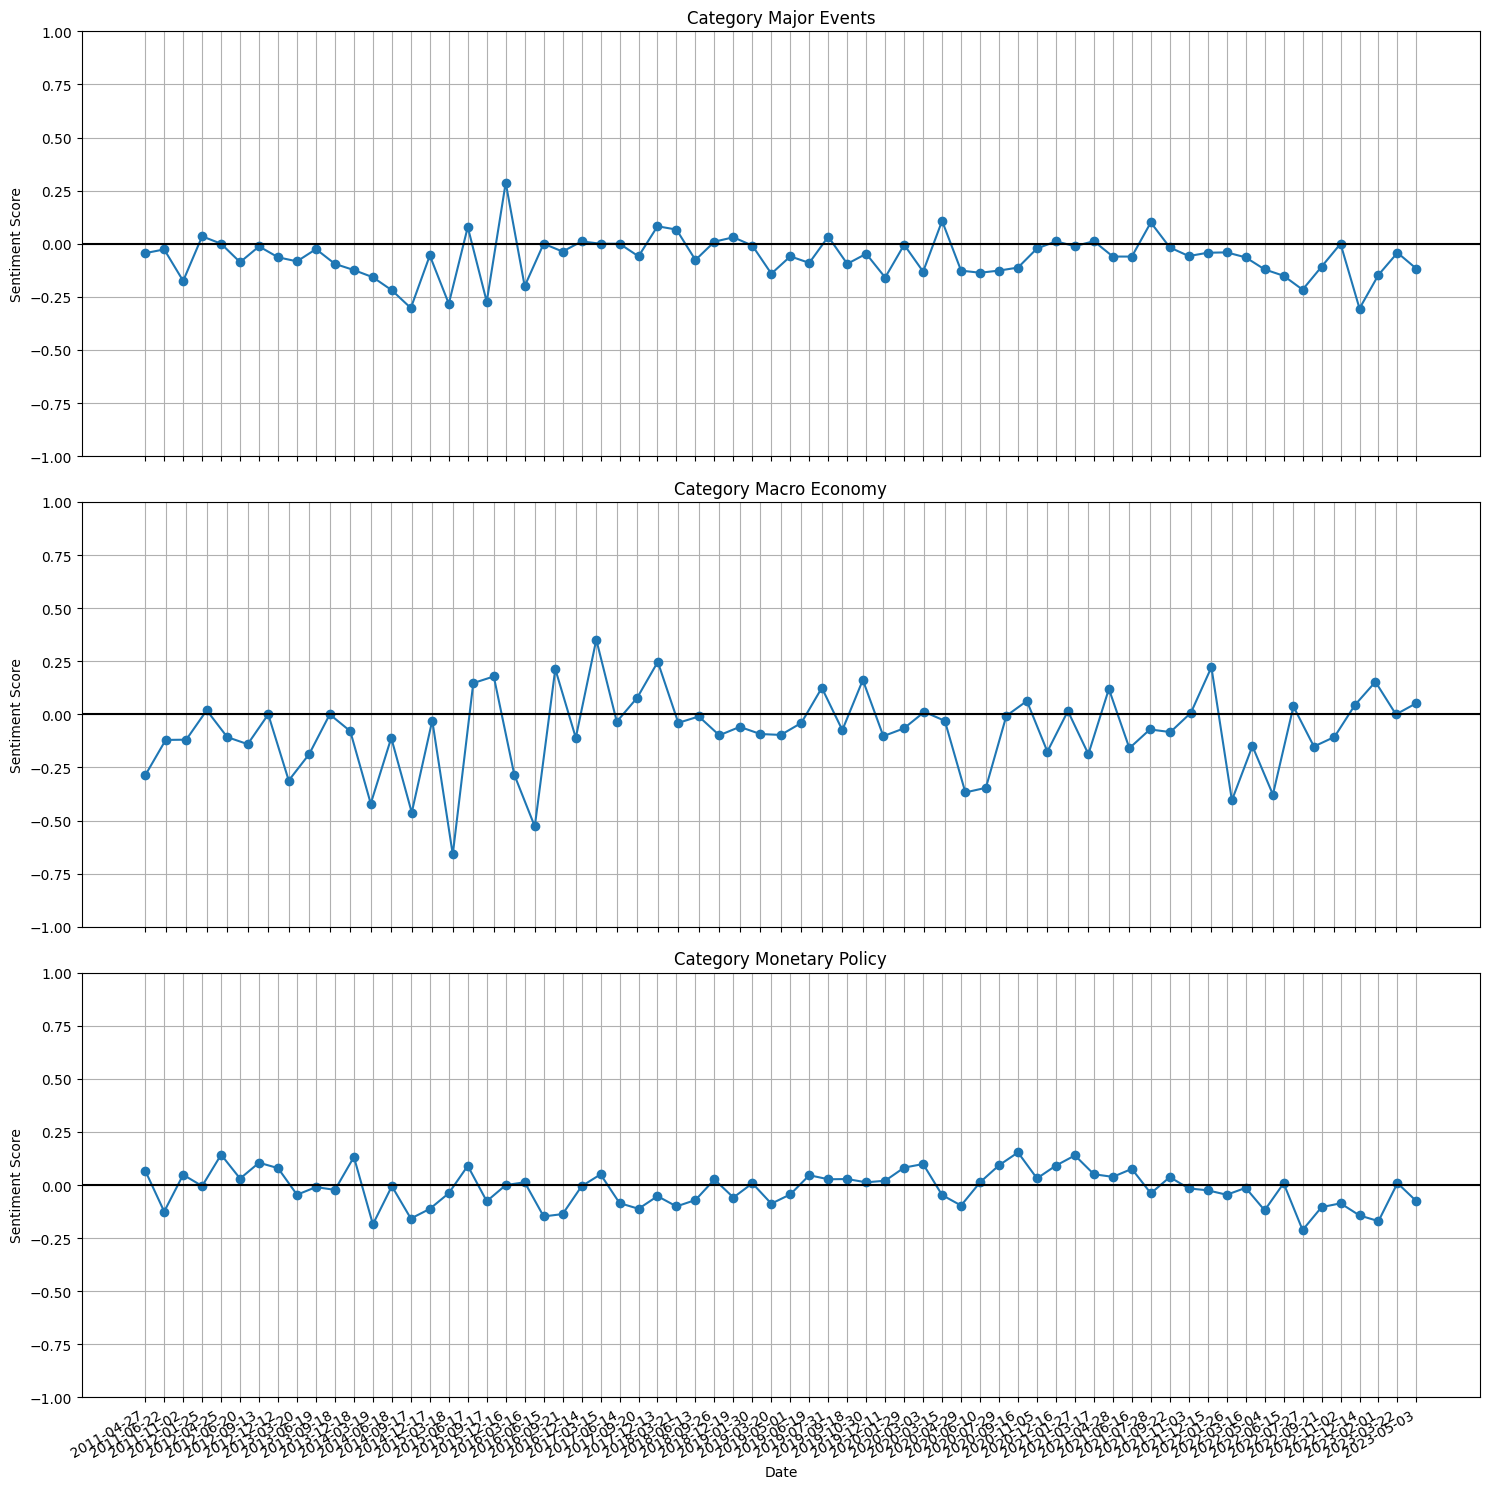

In [12]:
agg_df = df.groupby(['date', 'category']).mean().reset_index()

# Plotting
fig, axes = plt.subplots(3, 1, figsize=(15, 15))

categories = df['category'].unique()

for i, category in enumerate(categories):
    subset = agg_df[agg_df['category'] == category]
    axes[i].plot(subset['date'], subset['sentiment_score_2'], marker='o')
    axes[i].set_title(f'Category {category}')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Sentiment Score')
    axes[i].grid(True)
    axes[i].set_ylim([-1, 1])  # Assuming sentiment score is between -1 and 1
    axes[i].axhline(0, color='black', linewidth=1.5)
    fig.autofmt_xdate()  # Rotate x-labels for better formatting

plt.tight_layout()
plt.show()